# Heart Disease Classification with Neural Network

## Table of Contents
1. Import Libraries
2. Load Dataset
3. Exploratory Data Analysis (EDA)
4. Feature and Target Separation
5. Data Preprocessing
6. Model
7. K-Fold Cross-Validation

## 1. Import Libraries

In [65]:
import os
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

### 1.1 Seed Configuration

In [66]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

## 2. Load Dataset

In [67]:
DATA_PATH = "heart.csv"
TARGET_COL = "HeartDisease"

In [68]:
print("\n[STEP 1] Loading Data...")
print("-"*70)

df = pd.read_csv(DATA_PATH)
df


[STEP 1] Loading Data...
----------------------------------------------------------------------


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


### 2.1 Feature Type Definition

In [69]:
NUMERIC_COLS = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
CATEGORICAL_COLS = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope", "FastingBS"]

df[CATEGORICAL_COLS] = df[CATEGORICAL_COLS].astype("category")

### 2.2 Data Overview

In [70]:
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


### 2.3 Data Quality Check

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Age             918 non-null    int64   
 1   Sex             918 non-null    category
 2   ChestPainType   918 non-null    category
 3   RestingBP       918 non-null    int64   
 4   Cholesterol     918 non-null    int64   
 5   FastingBS       918 non-null    category
 6   RestingECG      918 non-null    category
 7   MaxHR           918 non-null    int64   
 8   ExerciseAngina  918 non-null    category
 9   Oldpeak         918 non-null    float64 
 10  ST_Slope        918 non-null    category
 11  HeartDisease    918 non-null    int64   
dtypes: category(6), float64(1), int64(5)
memory usage: 49.4 KB


In [72]:
df.dtypes

Age                  int64
Sex               category
ChestPainType     category
RestingBP            int64
Cholesterol          int64
FastingBS         category
RestingECG        category
MaxHR                int64
ExerciseAngina    category
Oldpeak            float64
ST_Slope          category
HeartDisease         int64
dtype: object

In [73]:
for col in CATEGORICAL_COLS:
    print(f"\nUnique values in '{col}': {df[col].nunique()}")


Unique values in 'Sex': 2

Unique values in 'ChestPainType': 4

Unique values in 'RestingECG': 3

Unique values in 'ExerciseAngina': 2

Unique values in 'ST_Slope': 3

Unique values in 'FastingBS': 2


In [74]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [75]:
df.duplicated().sum()

0

## 3. Exploratory Data Analysis (EDA)

### 3.1 Dataset Overview

In [76]:
print("\n" + "="*70)
print("[STEP 3] EXPLORATORY DATA ANALYSIS")
print("="*70)

print("\n[3.1] DATASET OVERVIEW")
print("-"*70)
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nData types:")
print(df.dtypes)


[STEP 3] EXPLORATORY DATA ANALYSIS

[3.1] DATASET OVERVIEW
----------------------------------------------------------------------
Shape: 918 rows × 12 columns
Memory usage: 0.05 MB

Data types:
Age                  int64
Sex               category
ChestPainType     category
RestingBP            int64
Cholesterol          int64
FastingBS         category
RestingECG        category
MaxHR                int64
ExerciseAngina    category
Oldpeak            float64
ST_Slope          category
HeartDisease         int64
dtype: object


### 3.2 Statistical Summary

In [77]:
print("\n[3.3] STATISTICAL SUMMARY - NUMERICAL FEATURES")
print("-"*70)
print(df[NUMERIC_COLS].describe().T.round(2))


[3.3] STATISTICAL SUMMARY - NUMERICAL FEATURES
----------------------------------------------------------------------
             count    mean     std   min     25%    50%    75%    max
Age          918.0   53.51    9.43  28.0   47.00   54.0   60.0   77.0
RestingBP    918.0  132.40   18.51   0.0  120.00  130.0  140.0  200.0
Cholesterol  918.0  198.80  109.38   0.0  173.25  223.0  267.0  603.0
MaxHR        918.0  136.81   25.46  60.0  120.00  138.0  156.0  202.0
Oldpeak      918.0    0.89    1.07  -2.6    0.00    0.6    1.5    6.2


### 3.3 Target Distribution


[3.4] TARGET VARIABLE DISTRIBUTION
----------------------------------------------------------------------

Class 0 (No Disease):   410 samples (44.66%)
Class 1 (Disease):      508 samples (55.34%)
Imbalance Ratio:      1.239


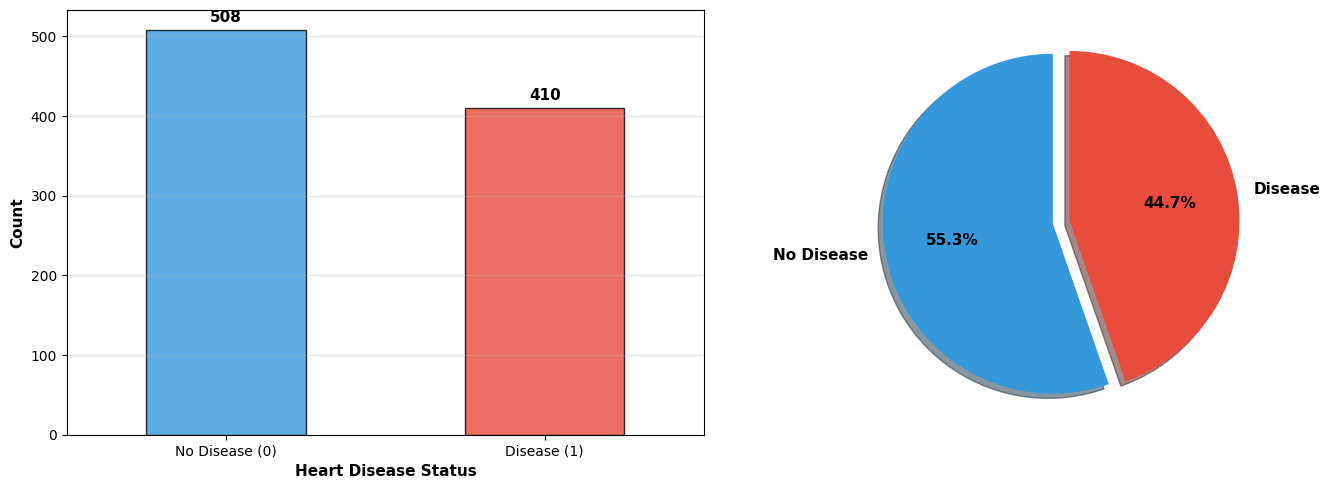

In [78]:
print("\n[3.4] TARGET VARIABLE DISTRIBUTION")
print("-"*70)

target_counts = df[TARGET_COL].value_counts()
target_pct = df[TARGET_COL].value_counts(normalize=True) * 100

print(f"\nClass 0 (No Disease): {target_counts[0]:>5} samples ({target_pct[0]:.2f}%)")
print(f"Class 1 (Disease):    {target_counts[1]:>5} samples ({target_pct[1]:.2f}%)")
print(f"Imbalance Ratio:      {target_counts[1] / target_counts[0]:.3f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ['#3498db', '#e74c3c']
target_counts.plot(kind='bar', ax=axes[0], color=colors, edgecolor='black', alpha=0.8)
axes[0].set_xlabel('Heart Disease Status', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=11, fontweight='bold')
axes[0].set_xticklabels(['No Disease (0)', 'Disease (1)'], rotation=0)
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate(target_counts):
    axes[0].text(i, v + 10, str(v), ha='center', fontweight='bold', fontsize=11)

axes[1].pie(target_counts, labels=['No Disease', 'Disease'], autopct='%1.1f%%',
            colors=colors, startangle=90, explode=(0.05, 0.05), shadow=True,
            textprops={'fontsize': 11, 'fontweight': 'bold'})

plt.tight_layout()
plt.show()

### 3.4 Feature Distribution


[1] NUMERICAL FEATURES DISTRIBUTION


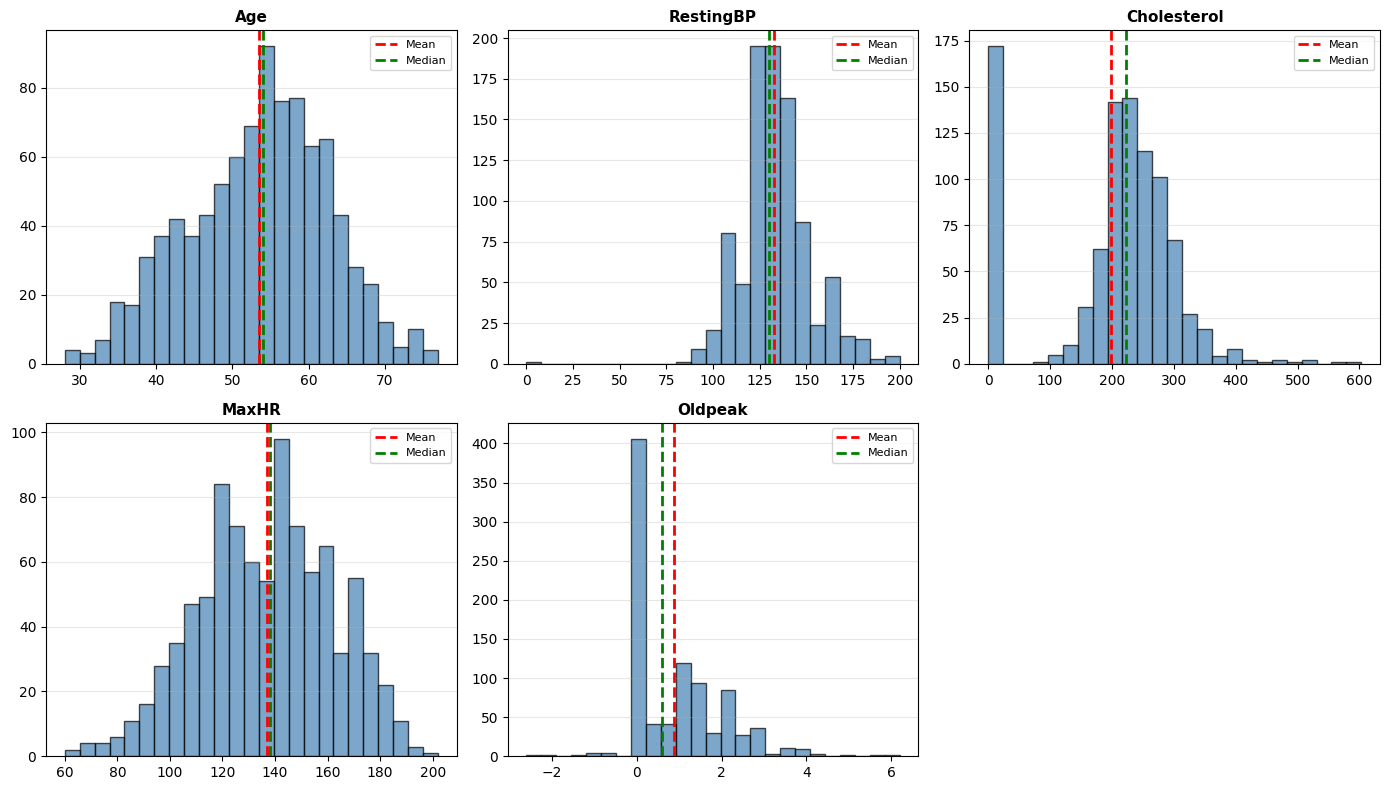


[2] CATEGORICAL FEATURES DISTRIBUTION


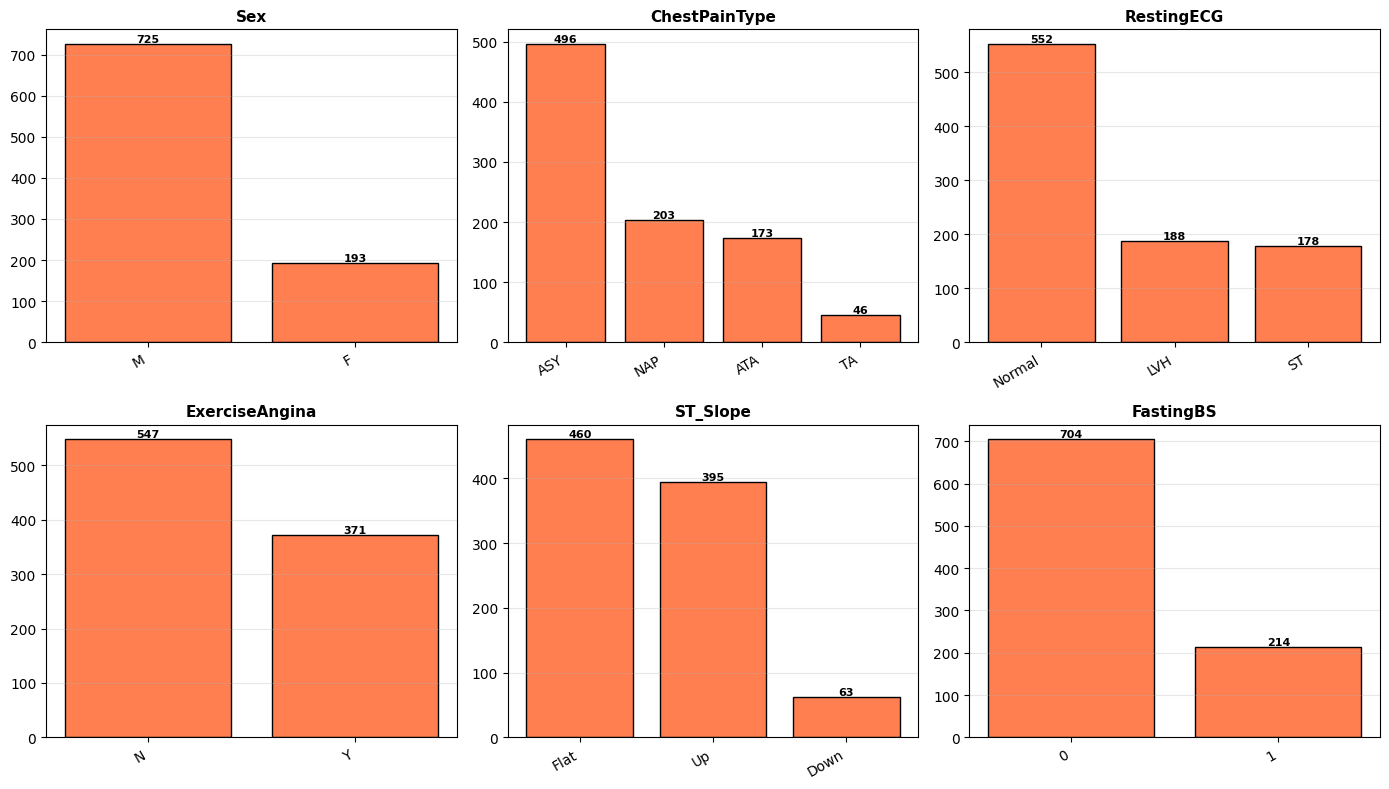

In [79]:
print("\n[1] NUMERICAL FEATURES DISTRIBUTION")
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(NUMERIC_COLS):
    mean_val = df[col].mean()
    median_val = df[col].median()
    axes[i].hist(df[col], bins=25, color='steelblue', alpha=0.7, edgecolor='black')
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label='Mean')
    axes[i].axvline(median_val, color='green', linestyle='--', linewidth=2, label='Median')
    axes[i].set_title(col, fontsize=11, fontweight='bold')
    axes[i].legend(fontsize=8)
    axes[i].grid(axis='y', alpha=0.3)

if len(NUMERIC_COLS) < len(axes):
    for j in range(len(NUMERIC_COLS), len(axes)):
        axes[j].axis('off')

plt.tight_layout()
plt.show()

print("\n[2] CATEGORICAL FEATURES DISTRIBUTION")
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(CATEGORICAL_COLS):
    counts = df[col].value_counts()
    axes[i].bar(counts.index.astype(str), counts.values, color='coral', edgecolor='black')
    axes[i].set_title(col, fontsize=11, fontweight='bold')
    axes[i].set_xticks(range(len(counts)))
    axes[i].set_xticklabels(counts.index, rotation=30, ha='right')
    axes[i].grid(axis='y', alpha=0.3)
    for x, y in enumerate(counts.values):
        axes[i].text(x, y, str(int(y)), ha='center', va='bottom', fontsize=8, fontweight='bold')

if len(CATEGORICAL_COLS) < len(axes):
    for j in range(len(CATEGORICAL_COLS), len(axes)):
        axes[j].axis('off')

plt.tight_layout()
plt.show()

### 3.5 Correlation Analysis


[3.7] CORRELATION ANALYSIS
----------------------------------------------------------------------

Correlation with Target Variable (All Features):
HeartDisease      1.000000
ExerciseAngina    0.494282
Oldpeak           0.403951
Sex               0.305445
Age               0.282039
FastingBS         0.267291
RestingBP         0.107589
RestingECG        0.057384
Cholesterol      -0.232741
ChestPainType    -0.386828
MaxHR            -0.400421
ST_Slope         -0.558771


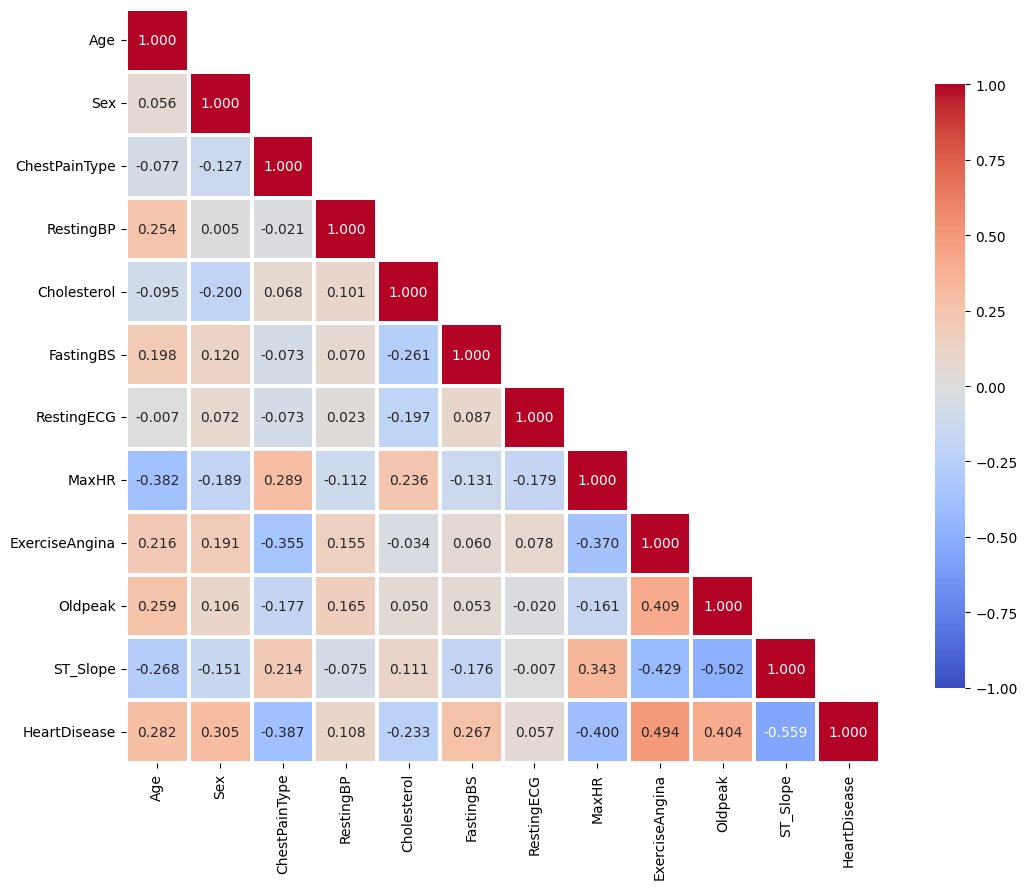

In [80]:
print("\n[3.7] CORRELATION ANALYSIS")
print("-"*70)

# Convert semua kolom kategorikal menjadi numerik
df_corr = df.copy()
for col in df_corr.columns:
    if df_corr[col].dtype == 'object' or df_corr[col].dtype.name == 'category':
        df_corr[col] = df_corr[col].astype('category').cat.codes

corr_matrix = df_corr.corr()

# Korelasi dengan target
target_corr = corr_matrix[TARGET_COL].sort_values(ascending=False)
print("\nCorrelation with Target Variable (All Features):")
print(target_corr.to_string())

plt.figure(figsize=(12, 9))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, square=True, linewidths=1.5, cbar_kws={"shrink": 0.8},
            mask=mask, vmin=-1, vmax=1)
plt.tight_layout()
plt.show()


## 4. Feature and Target Separation

In [81]:
assert TARGET_COL in df.columns, f"Target column '{TARGET_COL}' not found!"
y = df[TARGET_COL].astype(int).values
X = df.drop(columns=[TARGET_COL])

## 5. Data Preprocessing

In [82]:
preprocess = ColumnTransformer([
    ("num", StandardScaler(), NUMERIC_COLS),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), CATEGORICAL_COLS)
], remainder="drop")

## 6. Model

In [83]:
from tensorflow.keras.layers import Dropout

LR_ADAM = 0.001
BATCH_SIZE = 64
EPOCHS = 100
n_features = X.shape[1] 

In [84]:
from tensorflow.keras.optimizers import SGD

LR_SGD = 0.01
MOMENTUM_SGD = 0.9


## 7. K-Fold Cross-Validation

### 7.1 Cross-Validation Setup

In [85]:
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam, SGD

# Set parameters untuk K-Fold
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)

# Kombinasikan X dan y untuk K-Fold
X_combined = X
y_combined = y

print(f"\nTotal samples untuk cross-validation: {len(X_combined)}")
print(f"Number of folds: {n_splits}")
print(f"Fold size: ~{len(X_combined) // n_splits} samples\n")



Total samples untuk cross-validation: 918
Number of folds: 5
Fold size: ~183 samples



In [86]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD

# Tambahkan penyimpanan history
all_history_adam = []
all_history_sgd = []

# Struktur hasil
cv_results_adam = {
    'fold': [],

    'train_accuracy': [],
    'train_precision': [],
    'train_recall': [],
    'train_f1': [],

    'test_accuracy': [],
    'test_precision': [],
    'test_recall': [],
    'test_f1': [],

    'runtime': []
}

cv_results_sgd = {
    'fold': [],

    'train_accuracy': [],
    'train_precision': [],
    'train_recall': [],
    'train_f1': [],

    'test_accuracy': [],
    'test_precision': [],
    'test_recall': [],
    'test_f1': [],

    'runtime': []
}

fold_idx = 1

for train_idx, test_idx in kfold.split(X_combined):
    print(f"\n{'='*70}")
    print(f"[FOLD {fold_idx}/{n_splits}]")
    print(f"{'='*70}")

    # Split data
    X_train_fold_raw = X_combined.iloc[train_idx] if hasattr(X_combined,'iloc') else X_combined[train_idx]
    y_train_fold      = y_combined[train_idx]
    X_test_fold_raw   = X_combined.iloc[test_idx] if hasattr(X_combined,'iloc') else X_combined[test_idx]
    y_test_fold       = y_combined[test_idx]

    print(f"Train: {len(X_train_fold_raw)} | Test: {len(X_test_fold_raw)}")

    # Preprocessing fit hanya pada train
    preprocess.fit(X_train_fold_raw)
    X_train_fold = preprocess.transform(X_train_fold_raw)
    X_test_fold  = preprocess.transform(X_test_fold_raw)

    n_features = X_train_fold.shape[1]

    early_stop = EarlyStopping(
        monitor='loss',
        patience=10,
        restore_best_weights=True,
        verbose=0
    )
    
    # ==========================
    # 1. ADAM
    # ==========================
    print("\nRunning Adam...")

    model_adam = Sequential([
        Dense(128, activation='relu', input_shape=(n_features,)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model_adam.compile(
        optimizer=Adam(learning_rate=LR_ADAM),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    adam_start = time.time()
    history_adam = model_adam.fit(
        X_train_fold, y_train_fold,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=0,
        callbacks=[early_stop]
    ).history
    adam_runtime = time.time() - adam_start

    # Simpan history
    all_history_adam.append(history_adam)
    
    # METRIK TRAIN
    y_prob_train = model_adam.predict(X_train_fold, verbose=0).flatten()
    y_pred_train = (y_prob_train > 0.5).astype(int)

    train_acc = accuracy_score(y_train_fold, y_pred_train)
    train_prec = precision_score(y_train_fold, y_pred_train, zero_division=0)
    train_rec = recall_score(y_train_fold, y_pred_train, zero_division=0)
    train_f1 = f1_score(y_train_fold, y_pred_train, zero_division=0)

    # METRIK TEST
    y_prob_test = model_adam.predict(X_test_fold, verbose=0).flatten()
    y_pred_test = (y_prob_test > 0.5).astype(int)

    test_acc = accuracy_score(y_test_fold, y_pred_test)
    test_prec = precision_score(y_test_fold, y_pred_test, zero_division=0)
    test_rec = recall_score(y_test_fold, y_pred_test, zero_division=0)
    test_f1 = f1_score(y_test_fold, y_pred_test, zero_division=0)

    cv_results_adam['fold'].append(fold_idx)
    cv_results_adam['train_accuracy'].append(train_acc)
    cv_results_adam['train_precision'].append(train_prec)
    cv_results_adam['train_recall'].append(train_rec)
    cv_results_adam['train_f1'].append(train_f1)

    cv_results_adam['test_accuracy'].append(test_acc)
    cv_results_adam['test_precision'].append(test_prec)
    cv_results_adam['test_recall'].append(test_rec)
    cv_results_adam['test_f1'].append(test_f1)

    cv_results_adam['runtime'].append(adam_runtime)

    print(f"Adam Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f} | Time: {adam_runtime:.2f}s")


    # ==========================
    # 2. SGD
    # ==========================
    print("Running SGD...")

    model_sgd = Sequential([
        Dense(128, activation='relu', input_shape=(n_features,)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model_sgd.compile(
        optimizer=SGD(learning_rate=LR_SGD, momentum=MOMENTUM_SGD),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    sgd_start = time.time()
    history_sgd = model_sgd.fit(
        X_train_fold, y_train_fold,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=0,
        callbacks=[early_stop]
    ).history
    sgd_runtime = time.time() - sgd_start

    # Simpan history
    all_history_sgd.append(history_sgd)

    # TRAIN
    y_prob_train = model_sgd.predict(X_train_fold, verbose=0).flatten()
    y_pred_train = (y_prob_train > 0.5).astype(int)

    train_acc = accuracy_score(y_train_fold, y_pred_train)
    train_prec = precision_score(y_train_fold, y_pred_train, zero_division=0)
    train_rec = recall_score(y_train_fold, y_pred_train, zero_division=0)
    train_f1 = f1_score(y_train_fold, y_pred_train, zero_division=0)

    # TEST
    y_prob_test = model_sgd.predict(X_test_fold, verbose=0).flatten()
    y_pred_test = (y_prob_test > 0.5).astype(int)

    test_acc = accuracy_score(y_test_fold, y_pred_test)
    test_prec = precision_score(y_test_fold, y_pred_test, zero_division=0)
    test_rec = recall_score(y_test_fold, y_pred_test, zero_division=0)
    test_f1 = f1_score(y_test_fold, y_pred_test, zero_division=0)

    cv_results_sgd['fold'].append(fold_idx)
    cv_results_sgd['train_accuracy'].append(train_acc)
    cv_results_sgd['train_precision'].append(train_prec)
    cv_results_sgd['train_recall'].append(train_rec)
    cv_results_sgd['train_f1'].append(train_f1)

    cv_results_sgd['test_accuracy'].append(test_acc)
    cv_results_sgd['test_precision'].append(test_prec)
    cv_results_sgd['test_recall'].append(test_rec)
    cv_results_sgd['test_f1'].append(test_f1)

    cv_results_sgd['runtime'].append(sgd_runtime)

    print(f"SGD Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f} | Time: {sgd_runtime:.2f}s")

    fold_idx += 1





[FOLD 1/5]
Train: 734 | Test: 184

Running Adam...
Adam Train Acc: 0.9796 | Test Acc: 0.8913 | Time: 5.32s
Running SGD...
SGD Train Acc: 0.9183 | Test Acc: 0.8967 | Time: 4.88s

[FOLD 2/5]
Train: 734 | Test: 184

Running Adam...
Adam Train Acc: 0.9796 | Test Acc: 0.8587 | Time: 5.14s
Running SGD...
SGD Train Acc: 0.9292 | Test Acc: 0.8696 | Time: 4.86s

[FOLD 3/5]
Train: 734 | Test: 184

Running Adam...
Adam Train Acc: 0.9837 | Test Acc: 0.8750 | Time: 5.07s
Running SGD...
SGD Train Acc: 0.9346 | Test Acc: 0.8913 | Time: 4.92s

[FOLD 4/5]
Train: 735 | Test: 183

Running Adam...
Adam Train Acc: 0.9755 | Test Acc: 0.8142 | Time: 4.07s
Running SGD...
SGD Train Acc: 0.9497 | Test Acc: 0.8197 | Time: 5.32s

[FOLD 5/5]
Train: 735 | Test: 183

Running Adam...
Adam Train Acc: 0.9796 | Test Acc: 0.8525 | Time: 5.30s
Running SGD...
SGD Train Acc: 0.9415 | Test Acc: 0.8634 | Time: 4.95s


In [87]:
model_sgd.summary()

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_117 (Dense)               │ (None, 128)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,276 (87.02 KB)

 Trainable params: 11,137 (43.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,139 (43.52 KB)

In [88]:
model_adam.summary()

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_114 (Dense)               │ (None, 128)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,413 (130.52 KB)

 Trainable params: 11,137 (43.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,276 (87.02 KB)

### 7.2 Cross-Validation Results Summary

In [93]:
df_cv_adam = pd.DataFrame(cv_results_adam)
df_cv_sgd = pd.DataFrame(cv_results_sgd)

summary_adam = {
    'Optimizer': 'Adam',
    'Accuracy': f"{df_cv_adam['test_accuracy'].mean():.4f} ± {df_cv_adam['test_accuracy'].std():.4f}",
    'Precision': f"{df_cv_adam['test_precision'].mean():.4f} ± {df_cv_adam['test_precision'].std():.4f}",
    'Recall': f"{df_cv_adam['test_recall'].mean():.4f} ± {df_cv_adam['test_recall'].std():.4f}",
    'F1-Score': f"{df_cv_adam['test_f1'].mean():.4f} ± {df_cv_adam['test_f1'].std():.4f}",
    'Runtime': f"{df_cv_adam['runtime'].mean():.2f}s ± {df_cv_adam['runtime'].std():.2f}s"
}

summary_sgd = {
    'Optimizer': 'SGD',
    'Accuracy': f"{df_cv_sgd['test_accuracy'].mean():.4f} ± {df_cv_sgd['test_accuracy'].std():.4f}",
    'Precision': f"{df_cv_sgd['test_precision'].mean():.4f} ± {df_cv_sgd['test_precision'].std():.4f}",
    'Recall': f"{df_cv_sgd['test_recall'].mean():.4f} ± {df_cv_sgd['test_recall'].std():.4f}",
    'F1-Score': f"{df_cv_sgd['test_f1'].mean():.4f} ± {df_cv_sgd['test_f1'].std():.4f}",
    'Runtime': f"{df_cv_sgd['runtime'].mean():.2f}s ± {df_cv_sgd['runtime'].std():.2f}s"
}

print("\n[8.3] CROSS-VALIDATION RESULTS SUMMARY")
print("="*70)
print("\nPER FOLD RESULTS - ADAM:")
print("-"*70)
print(df_cv_adam.to_string(index=False))

print("\n\nPER FOLD RESULTS - SGD:")
print("-"*70)
print(df_cv_sgd.to_string(index=False))



[8.3] CROSS-VALIDATION RESULTS SUMMARY

PER FOLD RESULTS - ADAM:
----------------------------------------------------------------------
 fold  train_accuracy  train_precision  train_recall  train_f1  test_accuracy  test_precision  test_recall  test_f1  runtime
    1        0.979564         0.982500      0.980050  0.981273       0.891304        0.948454     0.859813 0.901961 5.316314
    2        0.979564         0.972569      0.989848  0.981132       0.858696        0.900000     0.868421 0.883929 5.138497
    3        0.983651         0.976190      0.995146  0.985577       0.875000        0.841121     0.937500 0.886700 5.069178
    4        0.975510         0.980344      0.975550  0.977941       0.814208        0.809524     0.858586 0.833333 4.067152
    5        0.979592         0.980815      0.983173  0.981993       0.852459        0.803738     0.934783 0.864322 5.298275


PER FOLD RESULTS - SGD:
----------------------------------------------------------------------
 fold  train_acc

In [94]:
print("\nTABEL HASIL CV - SGD")
print("="*70)
print(f"{'METRIK':15} | {'TRAIN':17} | {'TEST':17}")
print("-"*70)
print(f"{'Accuracy':15} | {df_cv_sgd['train_accuracy'].mean():.4f} ± {df_cv_sgd['train_accuracy'].std():.4f}   | {summary_sgd['Accuracy']}")
print(f"{'Precision':15} | {df_cv_sgd['train_precision'].mean():.4f} ± {df_cv_sgd['train_precision'].std():.4f}   | {summary_sgd['Precision']}")
print(f"{'Recall':15} | {df_cv_sgd['train_recall'].mean():.4f} ± {df_cv_sgd['train_recall'].std():.4f}   | {summary_sgd['Recall']}")
print(f"{'F1 Score':15} | {df_cv_sgd['train_f1'].mean():.4f} ± {df_cv_sgd['train_f1'].std():.4f}   | {summary_sgd['F1-Score']}")
print(f"{'Runtime':15} | {'-':17} | {summary_sgd['Runtime']}")

print("\nTABEL HASIL CV - ADAM")
print("="*70)
print(f"{'METRIK':15} | {'TRAIN':17} | {'TEST':17}")
print("-"*70)
print(f"{'Accuracy':15} | {df_cv_adam['train_accuracy'].mean():.4f} ± {df_cv_adam['train_accuracy'].std():.4f}   | {summary_adam['Accuracy']}")
print(f"{'Precision':15} | {df_cv_adam['train_precision'].mean():.4f} ± {df_cv_adam['train_precision'].std():.4f}   | {summary_adam['Precision']}")
print(f"{'Recall':15} | {df_cv_adam['train_recall'].mean():.4f} ± {df_cv_adam['train_recall'].std():.4f}   | {summary_adam['Recall']}")
print(f"{'F1 Score':15} | {df_cv_adam['train_f1'].mean():.4f} ± {df_cv_adam['train_f1'].std():.4f}   | {summary_adam['F1-Score']}")
print(f"{'Runtime':15} | {'-':17} | {summary_adam['Runtime']}")


TABEL HASIL CV - SGD
METRIK          | TRAIN             | TEST             
----------------------------------------------------------------------
Accuracy        | 0.9346 ± 0.0119   | 0.8681 ± 0.0305
Precision       | 0.9319 ± 0.0100   | 0.8661 ± 0.0539
Recall          | 0.9511 ± 0.0151   | 0.9034 ± 0.0369
F1 Score        | 0.9414 ± 0.0117   | 0.8831 ± 0.0277
Runtime         | -                 | 4.99s ± 0.19s

TABEL HASIL CV - ADAM
METRIK          | TRAIN             | TEST             
----------------------------------------------------------------------
Accuracy        | 0.9796 ± 0.0029   | 0.8583 ± 0.0289
Precision       | 0.9785 ± 0.0040   | 0.8606 ± 0.0622
Recall          | 0.9848 ± 0.0078   | 0.8918 ± 0.0406
F1 Score        | 0.9816 ± 0.0027   | 0.8740 ± 0.0264
Runtime         | -                 | 4.98s ± 0.52s


In [104]:
test_adam = {
    'Optimizer': 'Adam',
    'Accuracy': f"{df_cv_adam['test_accuracy'].mean():.4f}",
    'Precision': f"{df_cv_adam['test_precision'].mean():.4f}",
    'Recall': f"{df_cv_adam['test_recall'].mean():.4f}",
    'F1-Score': f"{df_cv_adam['test_f1'].mean():.4f}",
    'Runtime': f"{df_cv_adam['runtime'].mean():.2f}s"
}

test_sgd = {
    'Optimizer': 'SGD',
    'Accuracy': f"{df_cv_sgd['test_accuracy'].mean():.4f}",
    'Precision': f"{df_cv_sgd['test_precision'].mean():.4f}",
    'Recall': f"{df_cv_sgd['test_recall'].mean():.4f}",
    'F1-Score': f"{df_cv_sgd['test_f1'].mean():.4f}",
    'Runtime': f"{df_cv_sgd['runtime'].mean():.2f}s"
}

In [108]:
print("\nTABEL HASIL CV - SGD")
print("="*40)
print(f"{'METRIK':15} | {'TRAIN':6} | {'TEST':17}")
print("-"*40)
print(f"{'Accuracy':15} | {df_cv_sgd['train_accuracy'].mean():.4f} | {test_sgd['Accuracy']}")
print(f"{'Precision':15} | {df_cv_sgd['train_precision'].mean():.4f} | {test_sgd['Precision']}")
print(f"{'Recall':15} | {df_cv_sgd['train_recall'].mean():.4f} | {test_sgd['Recall']}")
print(f"{'F1 Score':15} | {df_cv_sgd['train_f1'].mean():.4f} | {test_sgd['F1-Score']}")
print(f"{'Runtime':15} | {'-':6} | {test_sgd['Runtime']}")
print("\nTABEL HASIL CV - ADAM")
print("="*40)
print(f"{'METRIK':15} | {'TRAIN':6} | {'TEST':17}")
print("-"*40)
print(f"{'Accuracy':15} | {df_cv_adam['train_accuracy'].mean():.4f} | {test_adam['Accuracy']}")
print(f"{'Precision':15} | {df_cv_adam['train_precision'].mean():.4f} | {test_adam['Precision']}")
print(f"{'Recall':15} | {df_cv_adam['train_recall'].mean():.4f} | {test_adam['Recall']}")
print(f"{'F1 Score':15} | {df_cv_adam['train_f1'].mean():.4f} | {test_adam['F1-Score']}")
print(f"{'Runtime':15} | {'-':6} | {test_adam['Runtime']}")


TABEL HASIL CV - SGD
METRIK          | TRAIN  | TEST             
----------------------------------------
Accuracy        | 0.9346 | 0.8681
Precision       | 0.9319 | 0.8661
Recall          | 0.9511 | 0.9034
F1 Score        | 0.9414 | 0.8831
Runtime         | -      | 4.99s

TABEL HASIL CV - ADAM
METRIK          | TRAIN  | TEST             
----------------------------------------
Accuracy        | 0.9796 | 0.8583
Precision       | 0.9785 | 0.8606
Recall          | 0.9848 | 0.8918
F1 Score        | 0.9816 | 0.8740
Runtime         | -      | 4.98s


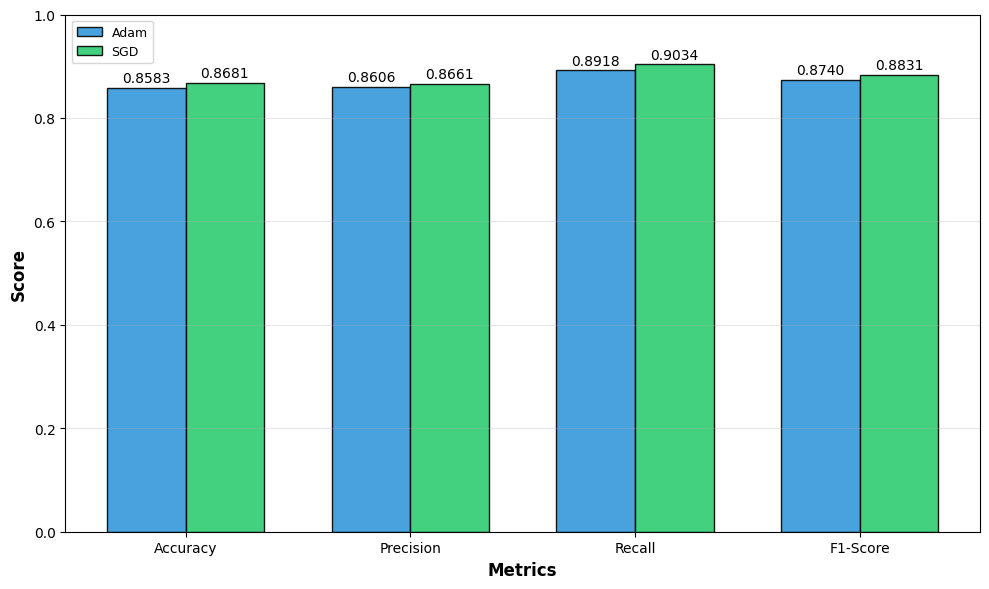

In [ ]:
# Metrics dan label
metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Hitung rata-rata tiap metrik dari hasil cross-validation
adam_means = [df_cv_adam[m].mean() for m in metrics]
sgd_means  = [df_cv_sgd[m].mean()  for m in metrics]

# Buat figure dengan ukuran yang nyaman
plt.figure(figsize=(10, 6))

x = np.arange(len(metrics))
width = 0.35

# Bar untuk Adam dan SGD
plt.bar(x - width/2, adam_means, width, label='Adam', color='#3498db', edgecolor='black', alpha=0.9)
plt.bar(x + width/2, sgd_means,  width, label='SGD',  color='#2ecc71', edgecolor='black', alpha=0.9)

# Kustomisasi
plt.xlabel('Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Score', fontsize=12, fontweight='bold')
# plt.title('Cross-Validation Results: Adam vs SGD', fontsize=14, fontweight='bold')
plt.xticks(x, metric_labels, rotation=0)
plt.ylim(0, 1.0)
plt.legend(fontsize=9)
plt.grid(True, axis='y', alpha=0.3)

# Tambahkan nilai di atas bar
for i, (adam_val, sgd_val) in enumerate(zip(adam_means, sgd_means)):
    plt.text(i - width/2, adam_val + 0.005, f'{adam_val:.4f}', ha='center', va='bottom', fontsize=10)
    plt.text(i + width/2,  sgd_val + 0.005,  f'{sgd_val:.4f}',  ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
h

NameError: name 'h' is not defined

### Hanya Test

In [ ]:
import matplotlib.pyplot as plt
import time

# Inisialisasi hasil CV
cv_results_adam = {
    'fold': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'runtime': []
}

cv_results_sgd = {
    'fold': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'runtime': []
}

# Melakukan K-Fold Cross-Validation
fold_idx = 1

# Simpan history untuk plotting nanti
all_history_adam = []
all_history_sgd  = []

for train_idx, test_idx in kfold.split(X_combined):
    print(f"\n{'='*70}")
    print(f"[FOLD {fold_idx}/{n_splits}]")
    print(f"{'='*70}")
    
    # Split data untuk fold ini
    X_train_fold_raw = X_combined.iloc[train_idx] if hasattr(X_combined, 'iloc') else X_combined[train_idx]
    y_train_fold      = y_combined[train_idx]
    X_test_fold_raw   = X_combined.iloc[test_idx] if hasattr(X_combined, 'iloc') else X_combined[test_idx]
    y_test_fold       = y_combined[test_idx]
    
    print(f"Train set: {len(X_train_fold_raw)} samples | Test set: {len(X_test_fold_raw)} samples")
    
    # PREPROCESSING: FIT HANYA DI TRAIN FOLD
    preprocess.fit(X_train_fold_raw)
    X_train_fold = preprocess.transform(X_train_fold_raw)
    X_test_fold  = preprocess.transform(X_test_fold_raw)
    
    # Callback
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=0
    )
    
    n_features = X_train_fold.shape[1]

    # ===== ADAM OPTIMIZER =====
    print(f"\n[ADAM Optimizer]")
    model_adam_fold = Sequential([
        Dense(128, activation='relu', input_shape=(n_features,)),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model_adam_fold.compile(
        optimizer=Adam(learning_rate=LR_ADAM),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    adam_start_time = time.time()
    history_adam_fold = model_adam_fold.fit(
        X_train_fold, y_train_fold,
        validation_split=None,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stop],
        verbose=0
    ).history   # simpan history sebagai dict
    adam_runtime = time.time() - adam_start_time
    
    all_history_adam.append(history_adam_fold)  # simpan untuk plotting
    
    # Prediksi & metrik
    y_prob_adam_fold = model_adam_fold.predict(X_test_fold, verbose=0).flatten()
    y_pred_adam_fold = (y_prob_adam_fold > 0.5).astype(int)
    
    acc_adam_fold  = accuracy_score(y_test_fold, y_pred_adam_fold)
    prec_adam_fold = precision_score(y_test_fold, y_pred_adam_fold, zero_division=0)
    rec_adam_fold  = recall_score(y_test_fold, y_pred_adam_fold, zero_division=0)
    f1_adam_fold   = f1_score(y_test_fold, y_pred_adam_fold, zero_division=0)
    
    cv_results_adam['fold'].append(fold_idx)
    cv_results_adam['accuracy'].append(acc_adam_fold)
    cv_results_adam['precision'].append(prec_adam_fold)
    cv_results_adam['recall'].append(rec_adam_fold)
    cv_results_adam['f1'].append(f1_adam_fold)
    cv_results_adam['runtime'].append(adam_runtime)
    
    print(f"  Accuracy:  {acc_adam_fold:.4f} | Precision: {prec_adam_fold:.4f} | Recall: {rec_adam_fold:.4f} | F1: {f1_adam_fold:.4f}")
    print(f"  Runtime Adam: {adam_runtime:.2f} seconds")
    
    # ===== SGD OPTIMIZER =====
    print(f"\n[SGD Optimizer]")
    model_sgd_fold = Sequential([
        Dense(128, activation='relu', input_shape=(n_features,)),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model_sgd_fold.compile(
        optimizer=SGD(learning_rate=LR_SGD, momentum=MOMENTUM_SGD),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    sgd_start_time = time.time()
    history_sgd_fold = model_sgd_fold.fit(
        X_train_fold, y_train_fold,
        validation_split=None,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stop],
        verbose=0
    ).history
    sgd_runtime = time.time() - sgd_start_time
    
    all_history_sgd.append(history_sgd_fold)
    
    y_prob_sgd_fold = model_sgd_fold.predict(X_test_fold, verbose=0).flatten()
    y_pred_sgd_fold = (y_prob_sgd_fold > 0.5).astype(int)
    
    acc_sgd_fold  = accuracy_score(y_test_fold, y_pred_sgd_fold)
    prec_sgd_fold = precision_score(y_test_fold, y_pred_sgd_fold, zero_division=0)
    rec_sgd_fold  = recall_score(y_test_fold, y_pred_sgd_fold, zero_division=0)
    f1_sgd_fold   = f1_score(y_test_fold, y_pred_sgd_fold, zero_division=0)
    
    cv_results_sgd['fold'].append(fold_idx)
    cv_results_sgd['accuracy'].append(acc_sgd_fold)
    cv_results_sgd['precision'].append(prec_sgd_fold)
    cv_results_sgd['recall'].append(rec_sgd_fold)
    cv_results_sgd['f1'].append(f1_sgd_fold)
    cv_results_sgd['runtime'].append(sgd_runtime)
    
    print(f"  Accuracy:  {acc_sgd_fold:.4f} | Precision: {prec_sgd_fold:.4f} | Recall: {rec_sgd_fold:.4f} | F1: {f1_sgd_fold:.4f}")
    print(f"  Runtime SGD: {sgd_runtime:.2f} seconds")
    
    fold_idx += 1


[FOLD 1/5]
Train set: 734 samples | Test set: 184 samples

[ADAM Optimizer]
  Accuracy:  0.8641 | Precision: 0.8942 | Recall: 0.8692 | F1: 0.8815
  Runtime Adam: 5.23 seconds

[SGD Optimizer]
  Accuracy:  0.9022 | Precision: 0.9159 | Recall: 0.9159 | F1: 0.9159
  Runtime SGD: 5.40 seconds

[FOLD 2/5]
Train set: 734 samples | Test set: 184 samples

[ADAM Optimizer]
  Accuracy:  0.8315 | Precision: 0.8807 | Recall: 0.8421 | F1: 0.8610
  Runtime Adam: 5.28 seconds

[SGD Optimizer]
  Accuracy:  0.8587 | Precision: 0.9000 | Recall: 0.8684 | F1: 0.8839
  Runtime SGD: 4.94 seconds

[FOLD 3/5]
Train set: 734 samples | Test set: 184 samples

[ADAM Optimizer]
  Accuracy:  0.8750 | Precision: 0.8411 | Recall: 0.9375 | F1: 0.8867
  Runtime Adam: 5.06 seconds

[SGD Optimizer]
  Accuracy:  0.8750 | Precision: 0.8614 | Recall: 0.9062 | F1: 0.8832
  Runtime SGD: 4.81 seconds

[FOLD 4/5]
Train set: 735 samples | Test set: 183 samples

[ADAM Optimizer]
  Accuracy:  0.8251 | Precision: 0.8384 | Recall: 

In [ ]:
df_cv_adam = pd.DataFrame(cv_results_adam)
df_cv_sgd = pd.DataFrame(cv_results_sgd)

summary_adam = {
    'Optimizer': 'Adam',
    'Accuracy (Mean ± Std)': f"{df_cv_adam['accuracy'].mean():.4f} ± {df_cv_adam['accuracy'].std():.4f}",
    'Precision (Mean ± Std)': f"{df_cv_adam['precision'].mean():.4f} ± {df_cv_adam['precision'].std():.4f}",
    'Recall (Mean ± Std)': f"{df_cv_adam['recall'].mean():.4f} ± {df_cv_adam['recall'].std():.4f}",
    'F1-Score (Mean ± Std)': f"{df_cv_adam['f1'].mean():.4f} ± {df_cv_adam['f1'].std():.4f}",
    'Runtime (Mean ± Std)': f"{df_cv_adam['runtime'].mean():.2f}s ± {df_cv_adam['runtime'].std():.2f}s"
}

summary_sgd = {
    'Optimizer': 'SGD',
    'Accuracy (Mean ± Std)': f"{df_cv_sgd['accuracy'].mean():.4f} ± {df_cv_sgd['accuracy'].std():.4f}",
    'Precision (Mean ± Std)': f"{df_cv_sgd['precision'].mean():.4f} ± {df_cv_sgd['precision'].std():.4f}",
    'Recall (Mean ± Std)': f"{df_cv_sgd['recall'].mean():.4f} ± {df_cv_sgd['recall'].std():.4f}",
    'F1-Score (Mean ± Std)': f"{df_cv_sgd['f1'].mean():.4f} ± {df_cv_sgd['f1'].std():.4f}",
    'Runtime (Mean ± Std)': f"{df_cv_sgd['runtime'].mean():.2f}s ± {df_cv_sgd['runtime'].std():.2f}s"
}

print("\n[8.3] CROSS-VALIDATION RESULTS SUMMARY")
print("="*70)
print("\nPER FOLD RESULTS - ADAM:")
print("-"*70)
print(df_cv_adam.to_string(index=False))

print("\n\nPER FOLD RESULTS - SGD:")
print("-"*70)
print(df_cv_sgd.to_string(index=False))


[8.3] CROSS-VALIDATION RESULTS SUMMARY

PER FOLD RESULTS - ADAM:
----------------------------------------------------------------------
 fold  accuracy  precision   recall       f1  runtime
    1  0.864130   0.894231 0.869159 0.881517 5.233716
    2  0.831522   0.880734 0.842105 0.860987 5.281404
    3  0.875000   0.841121 0.937500 0.886700 5.059635
    4  0.825137   0.838384 0.838384 0.838384 5.018034
    5  0.846995   0.796296 0.934783 0.860000 5.123968


PER FOLD RESULTS - SGD:
----------------------------------------------------------------------
 fold  accuracy  precision   recall       f1  runtime
    1  0.902174   0.915888 0.915888 0.915888 5.399196
    2  0.858696   0.900000 0.868421 0.883929 4.935966
    3  0.875000   0.861386 0.906250 0.883249 4.807781
    4  0.814208   0.803738 0.868687 0.834951 4.865484
    5  0.852459   0.803738 0.934783 0.864322 4.882661


In [ ]:


print("\n\n[MEAN & STANDARD DEVIATION]")
print("="*70)
print(f"\nAdam Optimizer:")
print(f"  Accuracy:  {summary_adam['Accuracy (Mean ± Std)']}")  
print(f"  Precision: {summary_adam['Precision (Mean ± Std)']}")   
print(f"  Recall:    {summary_adam['Recall (Mean ± Std)']}")   
print(f"  F1-Score:  {summary_adam['F1-Score (Mean ± Std)']}")   
print(f"  Runtime:   {summary_adam['Runtime (Mean ± Std)']}")

print(f"\nSGD Optimizer:")
print(f"  Accuracy:  {summary_sgd['Accuracy (Mean ± Std)']}")   
print(f"  Precision: {summary_sgd['Precision (Mean ± Std)']}")   
print(f"  Recall:    {summary_sgd['Recall (Mean ± Std)']}")   
print(f"  F1-Score:  {summary_sgd['F1-Score (Mean ± Std)']}")
print(f"  Runtime:   {summary_sgd['Runtime (Mean ± Std)']}")



[MEAN & STANDARD DEVIATION]

Adam Optimizer:
  Accuracy:  0.8486 ± 0.0211
  Precision: 0.8502 ± 0.0387
  Recall:    0.8844 ± 0.0487
  F1-Score:  0.8655 ± 0.0193
  Runtime:   5.14s ± 0.11s

SGD Optimizer:
  Accuracy:  0.8605 ± 0.0322
  Precision: 0.8570 ± 0.0525
  Recall:    0.8988 ± 0.0295
  F1-Score:  0.8765 ± 0.0297
  Runtime:   4.98s ± 0.24s


### 7.4 Visualisasi Cross-Validation Results

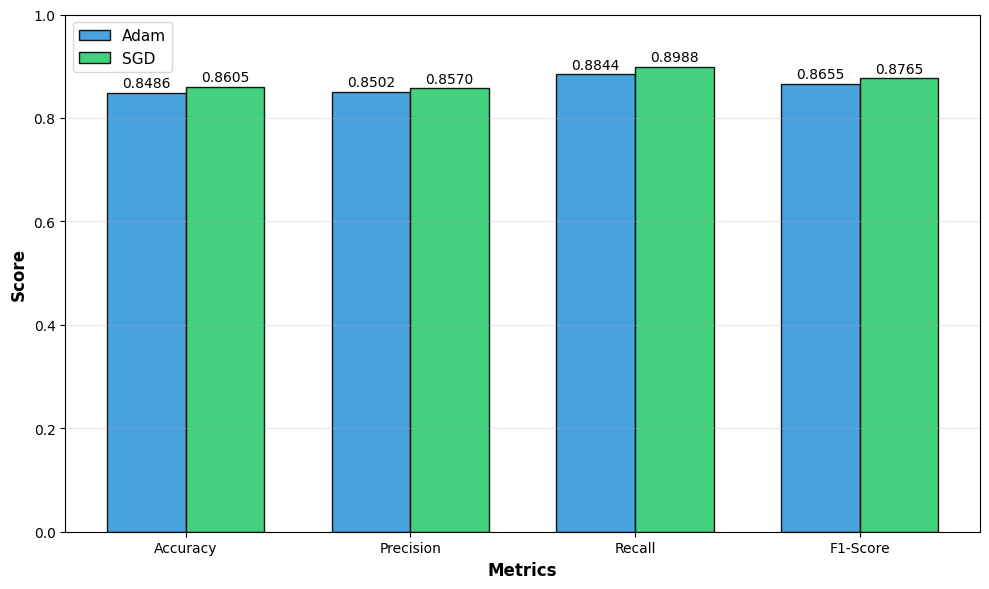

In [ ]:
# Metrics dan label
metrics = ['accuracy', 'precision', 'recall', 'f1']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Hitung rata-rata tiap metrik dari hasil cross-validation
adam_means = [df_cv_adam[m].mean() for m in metrics]
sgd_means  = [df_cv_sgd[m].mean()  for m in metrics]

# Buat figure dengan ukuran yang nyaman
plt.figure(figsize=(10, 6))

x = np.arange(len(metrics))
width = 0.35

# Bar untuk Adam dan SGD
plt.bar(x - width/2, adam_means, width, label='Adam', color='#3498db', edgecolor='black', alpha=0.9)
plt.bar(x + width/2, sgd_means,  width, label='SGD',  color='#2ecc71', edgecolor='black', alpha=0.9)

# Kustomisasi
plt.xlabel('Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Score', fontsize=12, fontweight='bold')
# plt.title('Cross-Validation Results: Adam vs SGD', fontsize=14, fontweight='bold')
plt.xticks(x, metric_labels, rotation=0)
plt.ylim(0, 1.0)
plt.legend(fontsize=11)
plt.grid(True, axis='y', alpha=0.3)

# Tambahkan nilai di atas bar
for i, (adam_val, sgd_val) in enumerate(zip(adam_means, sgd_means)):
    plt.text(i - width/2, adam_val + 0.005, f'{adam_val:.4f}', ha='center', va='bottom', fontsize=10)
    plt.text(i + width/2,  sgd_val + 0.005,  f'{sgd_val:.4f}',  ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### 7.4 Analisis & Kesimpulan Cross-Validation

In [ ]:
# Analisis hasil cross-validation
print("\n[8.5] ANALYSIS & CONCLUSION")
print("="*70)

# Hitung rata-rata untuk setiap metrik
adam_acc_mean = df_cv_adam['accuracy'].mean()
adam_prec_mean = df_cv_adam['precision'].mean()
adam_rec_mean = df_cv_adam['recall'].mean()
adam_f1_mean = df_cv_adam['f1'].mean()

sgd_acc_mean = df_cv_sgd['accuracy'].mean()
sgd_prec_mean = df_cv_sgd['precision'].mean()
sgd_rec_mean = df_cv_sgd['recall'].mean()
sgd_f1_mean = df_cv_sgd['f1'].mean()

# Bandingkan
comparison_cv = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Adam Mean': [adam_acc_mean, adam_prec_mean, adam_rec_mean, adam_f1_mean],
    'SGD Mean': [sgd_acc_mean, sgd_prec_mean, sgd_rec_mean, sgd_f1_mean]
})

comparison_cv['Difference (Adam - SGD)'] = comparison_cv['Adam Mean'] - comparison_cv['SGD Mean']
comparison_cv['Better'] = comparison_cv['Difference (Adam - SGD)'].apply(
    lambda x: 'Adam' if x > 0 else ('SGD' if x < 0 else 'Tie')
)

print("\nDetailed Comparison (Cross-Validation Averages):")
print("-"*70)
print(comparison_cv.to_string(index=False))

# Summary
print("\n[SUMMARY]")
print("-"*70)
adam_wins = (comparison_cv['Better'] == 'Adam').sum()
sgd_wins = (comparison_cv['Better'] == 'SGD').sum()
ties = (comparison_cv['Better'] == 'Tie').sum()

print(f"\nOptimizer Wins Breakdown:")
print(f"  Adam wins in: {adam_wins} metrics")
print(f"  SGD wins in:  {sgd_wins} metrics")
print(f"  Ties:        {ties} metrics")

# Overall winner based on average of all metrics
adam_overall = (adam_acc_mean + adam_prec_mean + adam_rec_mean + adam_f1_mean) / 4
sgd_overall = (sgd_acc_mean + sgd_prec_mean + sgd_rec_mean + sgd_f1_mean) / 4

print(f"\nOverall Average Performance (across all 5 metrics):")
print(f"  Adam: {adam_overall:.4f}")
print(f"  SGD:  {sgd_overall:.4f}")



[8.5] ANALYSIS & CONCLUSION

Detailed Comparison (Cross-Validation Averages):
----------------------------------------------------------------------
   Metric  Adam Mean  SGD Mean  Difference (Adam - SGD) Better
 Accuracy   0.848557  0.860507                -0.011951    SGD
Precision   0.850153  0.856950                -0.006797    SGD
   Recall   0.884386  0.898806                -0.014420    SGD
 F1-Score   0.865517  0.876468                -0.010950    SGD

[SUMMARY]
----------------------------------------------------------------------

Optimizer Wins Breakdown:
  Adam wins in: 0 metrics
  SGD wins in:  4 metrics
  Ties:        0 metrics

Overall Average Performance (across all 5 metrics):
  Adam: 0.8622
  SGD:  0.8732
